
#  ESCUELA POLITÉCNICA NACIONAL
## Ingeniería en Ciencias de la Computación
#### Ing. Iván Carrera
#### Kevin Valle - Daniel Samaniego



# 1. Importando librerias necesarias


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
sns.set_style('darkgrid')


# 2. Preparación de la Data

In [ ]:
df_review = pd.read_csv("IMDB Dataset.csv")
df_review

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Este modelo tiene 50000 filas, para un entrenamiento más rápido de nuestro modelo se usará una muestra de 10000 filas, va a contener 9000 revisiones positivas y 1000 negativas.

In [ ]:
df_positive = df_review[df_review['sentiment']=='positive'][:9000]
df_negative = df_review[df_review['sentiment']=='negative'][:1000]

df_review_imb = pd.concat([df_positive,df_negative ])

## Clases desbalanceadas

En la mayoría de los casos, tendrá una gran cantidad de datos para una clase y muchas menos observaciones para otras clases. Esto se conoce como datos desequilibrados porque el número de observaciones por clase no está distribuido equitativamente.


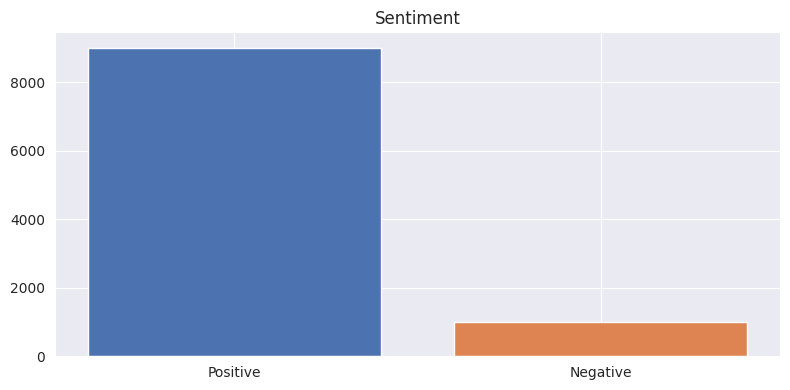

In [ ]:
colors = sns.color_palette('deep')

plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=df_review_imb.value_counts(['sentiment']),
        color=colors[:2])
plt.title('Sentiment')
plt.savefig('sentiment.png')
plt.show()

En este caso, usaremos RandomUnderSampler, para balancear los datos debido a que tenemos mas valores positivos que negativos.

In [ ]:
rus = RandomUnderSampler(random_state= 0)
df_review_bal,df_review_bal['sentiment']=rus.fit_resample(df_review_imb[['review']],df_review_imb['sentiment'])


df_review_bal

,review,sentiment
0,Basically there's a family where a little boy ...,negative
1,"This show was an amazing, fresh & innovative i...",negative
2,Encouraged by the positive comments about this...,negative
3,Phil the Alien is one of those quirky films wh...,negative
4,I saw this movie when I was about 12 when it c...,negative
...,...,...
1995,Knute Rockne led an extraordinary life and his...,positive
1996,At the height of the 'Celebrity Big Brother' r...,positive
1997,This is another of Robert Altman's underrated ...,positive
1998,This movie won a special award at Cannes for i...,positive


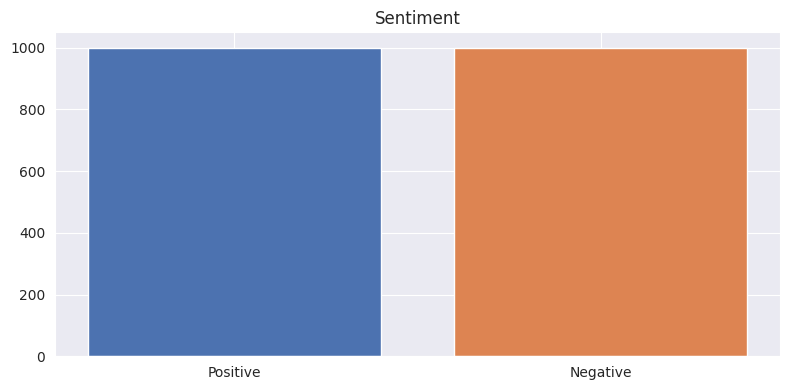

In [ ]:
colors = sns.color_palette('deep')

plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=df_review_bal.value_counts(['sentiment']),
        color=colors[:2])
plt.title('Sentiment')
plt.savefig('sentiment.png')
plt.show()

Comparamos el conjunto de datos equilibrado y desequilibrado.

In [ ]:
print(df_review_imb.value_counts('sentiment'))
print(df_review_bal.value_counts('sentiment'))

sentiment
positive    9000
negative    1000
dtype: int64
sentiment
negative    1000
positive    1000
dtype: int64


Dividimos los datos en entrenamiento y prueba.


In [ ]:
train,test = train_test_split(df_review_bal,test_size =0.33,random_state=42)

In [ ]:
train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

In [ ]:
train_y.value_counts()

negative    675
positive    665
Name: sentiment, dtype: int64


# 3.Representación de texto


Los clasificadores y los algoritmos de aprendizaje esperan vectores de características numéricas en lugar de documentos de texto sin formato. Por eso que necesitamos convertir nuestro texto de revisión de películas en vectores numéricos.

Usaremos bolsa de palabras (BOW) ya que nos importa la frecuencia de las palabras en las revisiones de texto; sin embargo, el orden de las palabras es irrelevante. Dos formas comunes de representar una bolsa de palabras son CountVectorizer y Term Frequency, Inverse Document Frequency (TF-IDF)

Para convertir datos de texto en vectores numéricos usaremos TF-IDF

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')    # Crea un vetorizador TF-IDF con el parámetro english, esto indica que se elimina las palabras en inglés de las reseñas
train_x_vector = tfidf.fit_transform(train_x)    # Se crea una matriz dispersa y contiene la frecuencia de cada palabra en cada reseña
# also fit the test_x_vector
test_x_vector = tfidf.transform(test_x)


Transformemos también el vector test_x, para que luego podamos probar la precisión del modelo.

In [ ]:
pd.DataFrame.sparse.from_spmatrix(train_x_vector,
                                  index=train_x.index,
                                  columns=tfidf.get_feature_names_out())   # Crea un DataFrame de Pandas a partir de la matriz dispersa, utilizando los índices y las columnas del conjunto de datos de entrenamiento

# 4.Selección de Modelo

Nuestra entrada (revisión) y salida (sentimiento) están claramente identificadas, por lo que podemos decir que hemos etiquetado los datos de entrada y salida; por lo tanto, estamos tratando con aprendizaje supervisado.



##  Support Vector Machine(SVM)


In [ ]:
svc = SVC(kernel='linear')
svc.fit(train_x_vector, train_y)

SVC(kernel='linear')

In [ ]:
print(svc.predict(tfidf.transform(['A good movie'])))
print(svc.predict(tfidf.transform(['An excellent movie'])))
print(svc.predict(tfidf.transform(['I did not like this movie at all I gave this movie away'])))

['positive']
['positive']
['negative']



# 5. Evaluación del modelo


## Mean Accuracy

In [ ]:
print(svc.score(test_x_vector, test_y))

0.8409090909090909


## F1 Score

La puntuación F1 es el promedio ponderado de precisión y recuperación. La precisión se utiliza cuando los verdaderos positivos y los verdaderos negativos son más importantes, mientras que la puntuación F1 se utiliza cuando los falsos negativos y los falsos positivos son cruciales. Además, F1 tiene en cuenta cómo se distribuyen los datos, por lo que es útil cuando tienes datos con clases de desequilibrio.

In [ ]:
f1_score(test_y,svc.predict(test_x_vector),
          labels = ['positive','negative'],average=None)

array([0.84671533, 0.83464567])

## Classification report

In [ ]:
print(classification_report(test_y,
                            svc.predict(test_x_vector),
                            labels = ['positive','negative']))

              precision    recall  f1-score   support

    positive       0.83      0.87      0.85       335
    negative       0.85      0.82      0.83       325

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



## Confusion Matrix

Una matriz de confusión es una tabla que permite visualizar el desempeño de un algoritmo. Esta tabla suele tener dos filas y dos columnas que informan el número de falsos positivos, falsos negativos, verdaderos positivos y verdaderos negativos.

In [ ]:
conf_mat = confusion_matrix(test_y,
                           svc.predict(test_x_vector),
                           labels = ['positive', 'negative'])
conf_mat

array([[290,  45],
       [ 60, 265]])

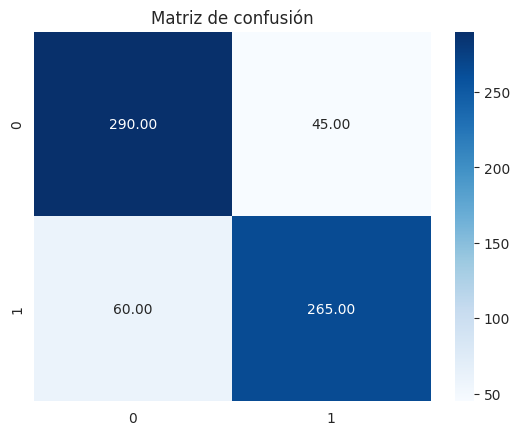

In [ ]:
sns.heatmap(conf_mat, annot=True, fmt=".2f", cmap="Blues")
plt.title("Matriz de confusión")
plt.show()